# Dead Sea mesh

## Tools

*Modules*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import shapely.ops
import h3
import json
from pyproj import Transformer
import matplotlib.pyplot as plt
from matplotlib import patheffects

In [2]:
plt.style.use('myfig.mplstyle')

*Paths*

In [3]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Dead Sea shapefile*

In [4]:
crs_geo = 'EPSG:4326'
crs_utm = 'EPSG:32636'

In [5]:
dead_sea_shp_geo = gpd.read_file("{:}/Dead_sea_shapefile/dead_sea.shp".format(datadir))
dead_sea_shp_utm = dead_sea_shp_geo.to_crs(crs_utm)

In [6]:
x_dead_sea, y_dead_sea = dead_sea_shp_utm.geometry[0].exterior.xy
x_dead_sea = np.array(x_dead_sea)
y_dead_sea = np.array(y_dead_sea)

## Pack Dead Sea shapefile with circles

In [7]:
# resolution of mesh in integer range: 0-15, where 0 is the coarsest resolution and 15 the finest
resolution = 8

In [8]:
# fill Dead Sea shapefile with hexagons
geoJson_deadsea = h3.geo_to_h3shape(json.loads(dead_sea_shp_geo.to_json())['features'][0]['geometry'])
hex_ = h3.polygon_to_cells(geoJson_deadsea, res=resolution)

# get hexagon centers and convert them to lat/lon and utm
centroids = [h3.cell_to_latlng(x) for x in hex_]
lats = [x[0] for x in centroids]
lons = [x[1] for x in centroids]

transformer = Transformer.from_crs(crs_geo, crs_utm)
centroids = transformer.transform(lats, lons)
x = centroids[0]
y = centroids[1]

In [9]:
# Create hexagon data frame
hexagons = pd.DataFrame(hex_, columns=["hex_id"])

# Create hexagon geometry and GeoDataFrame
hexagons['geometry'] = [Polygon(h3.cell_to_boundary(x)) for x in hexagons["hex_id"]]
hexagons = gpd.GeoDataFrame(hexagons)
hexagons_geo = hexagons.set_crs(crs_geo)
hexagons_geo['geometry'] = hexagons_geo['geometry'].apply(lambda geom: shapely.ops.transform(lambda x, y: (y, x), geom))

hexagons_utm = hexagons_geo.to_crs(crs_utm)

# Add hexagons centers
hexagons_geo['lat'] = lats
hexagons_geo['lon'] = lons
hexagons_geo['radius'] = h3.average_hexagon_edge_length(resolution, unit='m')
hexagons_geo['proj'] = crs_geo

hexagons_utm['x'] = x
hexagons_utm['y'] = y
hexagons_utm['radius'] = h3.average_hexagon_edge_length(resolution, unit='m')
hexagons_utm['proj'] = crs_utm

In [10]:
Ndisk = len(hexagons)
radius_disk = h3.average_hexagon_edge_length(resolution, unit='m') # m
surface_disk = np.pi * radius_disk**2 / 1e6 # km2
surface_dead_sea = dead_sea_shp_geo.Lake_area.values[0] # km2

print("{:} disks of radius {:.2f} m and surface {:.2f} km2".format(Ndisk, radius_disk, surface_disk))

print('surface: {:.1f}/{:.1f} km2 ({:.1f} %)'.format(Ndisk*surface_disk, surface_dead_sea, Ndisk*surface_disk/surface_dead_sea*100))

770 disks of radius 461.35 m and surface 0.67 km2
surface: 514.9/643.2 km2 (80.1 %)


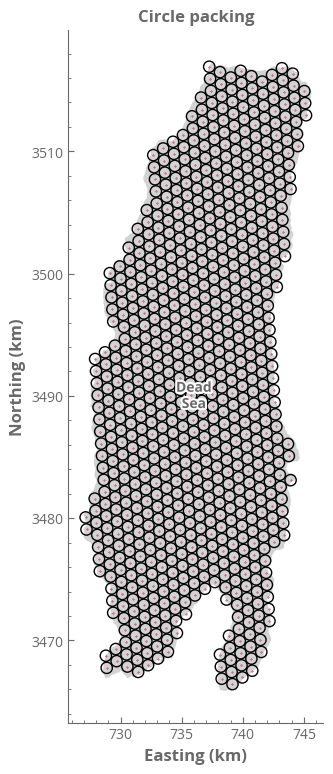

In [11]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.fill(x_dead_sea/1e3, y_dead_sea/1e3, facecolor='lightgrey')
ax.set_aspect('equal')

ax.scatter(hexagons_utm.x/1e3, hexagons_utm.y/1e3, s=.1)

for k in range(len(hexagons_utm)):
        ax.add_patch(plt.Circle((hexagons_utm.x[k]/1e3, hexagons_utm.y[k]/1e3),
                                radius_disk/1e3,
                                facecolor='None', edgecolor='k'))

ax.set_xlabel('Easting (km)')
ax.set_ylabel('Northing (km)')
ax.text(736, 3490, 'Dead\nSea', va='center', ha='center',
        fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax.set_title('Circle packing')

fig.savefig("{:}/dead_sea_mesh_disk_res{:}.png".format(plotdir, resolution), dpi=300, bbox_inches='tight')
plt.show()

*Export disks centers*

In [13]:
hexagons_geo.to_csv("{:}/Dead_Sea_mesh/mesh_geo_res{:}.txt".format(datadir, resolution),
                    columns=['proj', 'lon', 'lat', 'radius'],
                    sep='\t', index=False)

hexagons_utm.to_csv("{:}/Dead_Sea_mesh/mesh_utm_res{:}.txt".format(datadir, resolution),
                    columns=['proj', 'x', 'y', 'radius'],
                    sep='\t', index=False)